Using device: cpu
Epoch 0, PDE loss=7.7172e-04, BC loss=1.5669e+00, total=1.5677e+00
Epoch 500, PDE loss=1.4212e-02, BC loss=2.6686e-01, total=2.8107e-01
Epoch 1000, PDE loss=1.3255e-02, BC loss=2.6991e-01, total=2.8317e-01
Epoch 1500, PDE loss=1.2514e-02, BC loss=2.6256e-01, total=2.7507e-01
Epoch 2000, PDE loss=1.3726e-02, BC loss=2.6699e-01, total=2.8071e-01
Epoch 2500, PDE loss=1.4093e-02, BC loss=2.6432e-01, total=2.7841e-01
Epoch 3000, PDE loss=1.3313e-02, BC loss=2.6240e-01, total=2.7572e-01
Epoch 3500, PDE loss=1.1845e-02, BC loss=2.6729e-01, total=2.7913e-01
Epoch 4000, PDE loss=1.4168e-02, BC loss=2.5521e-01, total=2.6938e-01
Epoch 4500, PDE loss=1.4886e-02, BC loss=2.5577e-01, total=2.7065e-01

Training complete.



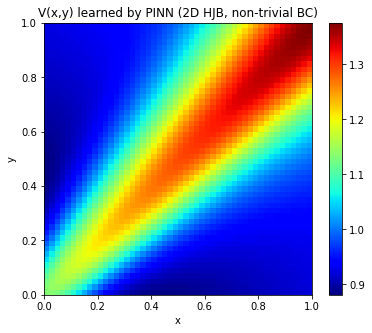

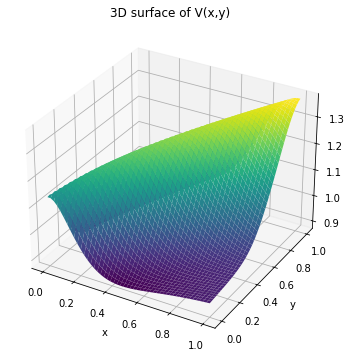

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
2D HJB Example with Non-Trivial Boundary Conditions
and Continuous Control a in [-1,1].

PDE:
  -r * V(x,y)
  + max_{a in [-1,1]}
    [ (x + a)*V_x + (y + a)*V_y - alpha*a^2 ]
  = 0
  for (x,y) in (0,1)x(0,1).

Boundary Conditions (non-trivial):
  V(0,y) = y
  V(1,y) = 1 + y
  V(x,0) = x
  V(x,1) = x + 1
  i.e. each edge has a different BC.

Interpretation:
  r>0 is a discount factor,
  alpha>0 is a penalty on control^2.
  We define the PDE's sup over a in [-1,1] by:
    a_unclamped = (V_x + V_y)/(2 alpha),
    a_star = clamp(a_unclamped, -1, 1).

PINN Approach:
  - Let V_theta(x,y) be a neural net.
  - PDE residual => R(x,y) = -r*V + (x+a_star)*V_x + (y+a_star)*V_y - alpha*a_star^2.
  - The boundary condition is enforced by MSE( V-theta(boundary) - bc_value ).
  - We log PDE loss, BC loss, total loss each iteration.
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # for 3D surface plots

# -------------------- PDE/Control Parameters --------------------
r = 0.05
alpha = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------------------------------------------
#  Neural Network for V(x,y)
# ----------------------------------------------------------------
class HJB2DNet(nn.Module):
    """
    A feed-forward network for V(x,y).
    Inputs: (x,y), each in [0,1].
    Output: scalar V(x,y).
    """
    def __init__(self, hidden_units=64):
        super(HJB2DNet, self).__init__()
        self.layer1 = nn.Linear(2, hidden_units)
        self.layer2 = nn.Linear(hidden_units, hidden_units)
        self.layer3 = nn.Linear(hidden_units, 1)
        self.activation = nn.Tanh()

    def forward(self, xy):
        # xy shape: (N,2), columns [x,y]
        out = self.activation(self.layer1(xy))
        out = self.activation(self.layer2(out))
        out = self.layer3(out)
        return out

# ----------------------------------------------------------------
#  PDE Residual
# ----------------------------------------------------------------
def hjb_2d_residual(model, x, y):
    """
    PDE:
      -r V + max_{a in [-1,1]} [ (x+a)*Vx + (y+a)*Vy - alpha*a^2 ] = 0.

    We do:
      a_unclamped = (Vx + Vy)/(2 alpha),
      a_star = clamp(a_unclamped, -1, 1).

    => residual = -r V + (x+a_star)*Vx + (y+a_star)*Vy - alpha(a_star^2).
    """
    x.requires_grad_(True)
    y.requires_grad_(True)

    XY = torch.cat([x,y], dim=1)  # shape (N,2)
    V = model(XY)                 # shape (N,1)

    # partial derivatives
    Vx = torch.autograd.grad(V, x, grad_outputs=torch.ones_like(V),
                             create_graph=True)[0]
    Vy = torch.autograd.grad(V, y, grad_outputs=torch.ones_like(V),
                             create_graph=True)[0]

    # unconstrained optimum
    a_unclamped = (Vx + Vy)/(2*alpha)
    a_star = torch.clamp(a_unclamped, -1.0, 1.0)

    expr = (x+a_star)*Vx + (y+a_star)*Vy - alpha*(a_star**2)
    residual = -r*V + expr
    return residual

# ----------------------------------------------------------------
#  Non-Trivial Boundary Condition
# ----------------------------------------------------------------
def boundary_condition(x, y):
    """
    Return the exact boundary value for V on each edge:
      - x=0 => V(0,y)= y
      - x=1 => V(1,y)= 1 + y
      - y=0 => V(x,0)= x
      - y=1 => V(x,1)= x + 1

    We'll detect which boundary by checking if x<1e-6, x>1-1e-6, etc.
    If a point belongs to multiple edges (corners), any consistent formula works.
    """
    # default
    bc_val = torch.zeros_like(x)
    tol = 1e-6

    # left edge x=0 => V= y
    mask_left = (x < tol)
    bc_val[mask_left] = y[mask_left]

    # right edge x=1 => V= 1 + y
    mask_right = (x > 1.0 - tol)
    bc_val[mask_right] = 1.0 + y[mask_right]

    # bottom edge y=0 => V= x
    mask_bottom = (y < tol)
    bc_val[mask_bottom] = x[mask_bottom]

    # top edge y=1 => V= x+1
    mask_top = (y > 1.0 - tol)
    bc_val[mask_top] = x[mask_top] + 1.0

    return bc_val

# ----------------------------------------------------------------
#  Sampling
# ----------------------------------------------------------------
def sample_interior(N):
    """
    Return random points (x,y) in (0,1)x(0,1).
    shape: (N,1) each.
    """
    x = torch.rand((N,1), device=device)
    y = torch.rand((N,1), device=device)
    return x, y

def sample_boundary(N):
    """
    Return points on boundary of the unit square, shape (4N,2).
    We'll sample N points for each edge.
    The function 'boundary_condition(x,y)' gives the target values.
    """
    x_rand = torch.rand((N,1), device=device)
    y_rand = torch.rand((N,1), device=device)

    # top    y=1
    top = torch.cat([x_rand, torch.ones_like(x_rand)], dim=1)
    # bottom y=0
    bottom = torch.cat([x_rand, torch.zeros_like(x_rand)], dim=1)
    # left   x=0
    left = torch.cat([torch.zeros_like(y_rand), y_rand], dim=1)
    # right  x=1
    right = torch.cat([torch.ones_like(y_rand), y_rand], dim=1)

    boundary = torch.cat([top, bottom, left, right], dim=0)  # shape (4N,2)
    return boundary

# ----------------------------------------------------------------
#  Main
# ----------------------------------------------------------------
def main():
    # Hyperparams
    hidden_units = 64
    lr = 1e-3
    num_epochs = 5000
    N_interior = 2000
    N_boundary = 400

    model = HJB2DNet(hidden_units=hidden_units).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        # 1) PDE residual inside domain
        x_in, y_in = sample_interior(N_interior)
        res_in = hjb_2d_residual(model, x_in, y_in)
        loss_pde = torch.mean(res_in**2)

        # 2) Boundary condition
        boundary_xy = sample_boundary(N_boundary)  # shape (4N,2)
        V_bdy = model(boundary_xy)                 # predicted
        # compute exact BC
        x_b = boundary_xy[:,0:1]
        y_b = boundary_xy[:,1:2]
        bc_true = boundary_condition(x_b, y_b)
        loss_bc = torch.mean((V_bdy - bc_true)**2)

        # total loss
        loss = loss_pde + loss_bc
        loss.backward()
        optimizer.step()

        # log every 500 epochs
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, PDE loss={loss_pde.item():.4e}, BC loss={loss_bc.item():.4e}, total={loss.item():.4e}")

    print("\nTraining complete.\n")

    # Evaluate on a grid for visualization
    Nx, Ny = 50, 50
    x_lin = torch.linspace(0,1,Nx, device=device)
    y_lin = torch.linspace(0,1,Ny, device=device)
    XX, YY = torch.meshgrid(x_lin, y_lin, indexing='xy')
    XY_flat = torch.cat([XX.reshape(-1,1), YY.reshape(-1,1)], dim=1)
    model.eval()
    with torch.no_grad():
        V_pred = model(XY_flat).cpu().numpy().reshape(Nx, Ny)

    # Plot 2D colormap
    plt.figure(figsize=(6,5))
    plt.imshow(
        V_pred.T,  # note transpose so x is horizontal
        origin='lower',
        extent=[0,1,0,1],
        aspect='auto',
        cmap='jet'
    )
    plt.colorbar()
    plt.title("V(x,y) learned by PINN (2D HJB, non-trivial BC)")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

    # 3D surface plot
    X_np = XX.cpu().numpy()
    Y_np = YY.cpu().numpy()
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X_np, Y_np, V_pred, cmap='viridis')
    ax.set_title("3D surface of V(x,y)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("V")
    plt.show()

if __name__ == "__main__":
    main()
